In [4]:
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class Poisson(object):
    cache_pmf = {}
    cache_sf = {}
    cache = {}
    MAX_CUTOFF = 25

    @classmethod
    def pmf_series(cls, mu, cutoff):
        assert isinstance(mu, int), "mu should be an integer."
        assert isinstance(cutoff, int), "cutoff should be an integer"

        if (mu, cutoff) not in cls.cache:
            cls._calculate_pmf_series(mu, cutoff)

        return cls.cache[(mu, cutoff)]

    @classmethod
    def _calculate_pmf_series(cls, mu, cutoff):

        if mu not in cls.cache_pmf:
            print("Calculate poisson ...")
            cls.cache_pmf[mu] = poisson.pmf(np.arange(cls.MAX_CUTOFF + 1), mu)
            cls.cache_sf[mu] = poisson.sf(np.arange(cls.MAX_CUTOFF + 1), mu)

        out = np.copy(cls.cache_pmf[mu][:cutoff+1])
        out[-1] += cls.cache_sf[mu][cutoff]

        cls.cache[(mu, cutoff)] = out

In [2]:
class PolicyIterationSolver(object):

    capacity = 20
    rental_reward = 10.
    moving_cost = 1.
    max_moving = 5

    bad_action_cost = 100.

    request_mean_G1 = 3
    request_mean_G2 = 3
    return_mean_G1 = 3
    return_mean_G2 = 2

    discount = 0.9

    PolicyEvaluationError = 0.01

    policy = None
    value = None

    def __init__(self):
        self.policy = np.zeros([self.capacity + 1]*2, int)
        self.value = np.zeros([self.capacity + 1]*2)

        self._reward1 = self.expected_rental_reward(self.request_mean_G1)
        self._reward2 = self.expected_rental_reward(self.request_mean_G2)

        assert self.bad_action_cost >= 0

    def bellman(self, action, s1, s2):
        transp1 = self.transition_probabilty(
            s1, self.request_mean_G1, self.return_mean_G1, -action)
        transp2 = self.transition_probabilty(
            s2, self.request_mean_G2, self.return_mean_G2, action)
        transp = np.outer(transp1, transp2)

        return self._reward1[s1] + self._reward2[s2] - self.expected_moving_cost(s1, s2, action) + \
            self.discount * sum((transp * self.value).flat)

    # policy evaluation
    def policy_evaluation(self):
        while True:
            diff = 0.
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                _temp = self.value[s1, s2]

                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)

                diff = max(diff, abs(self.value[s1, s2] - _temp))

                it.iternext()

            print(diff)
            if diff < self.PolicyEvaluationError:
                break

    def policy_update(self):
        is_policy_changed = False

        it = np.nditer([self.policy], flags=['multi_index'])
        while not it.finished:
            s1, s2 = it.multi_index

            _max_val = -1
            _pol = None

            for act in range(-self.max_moving, self.max_moving + 1):
                _val = self.bellman(action=act, s1=s1, s2=s2)
                if _val > _max_val:
                    _max_val = _val
                    _pol = act

            if self.policy[s1, s2] != _pol:
                is_policy_changed = True
                self.policy[s1, s2] = _pol

            it.iternext()

        return is_policy_changed

    def expected_moving_cost(self, s1, s2, action):
        if action == 0:
            return 0.

        # moving from state s1 into state s2
        if action > 0:
            p = self.transition_probabilty(
                s1, self.request_mean_G1, self.return_mean_G1)
            cost = self._gen_move_cost_array(action)
            return cost.dot(p)

        # moving from state s2 into state s1
        p = self.transition_probabilty(
            s2, self.request_mean_G2, self.return_mean_G2)
        cost = self._gen_move_cost_array(action)
        return cost.dot(p)

    def _gen_move_cost_array(self, action):
        _action = abs(action)

        # Don't punish bad action:
        if self.bad_action_cost == 0:
            cost = np.asarray(
                [ii if ii < _action else _action for ii in range(
                    self.capacity+1)]
            ) * self.moving_cost

        # bad action is punished
        else:
            cost = np.asarray(
                [self.bad_action_cost if ii <
                    _action else _action for ii in range(self.capacity + 1)]
            ) * self.moving_cost
        return cost

    @classmethod
    def expected_rental_reward(cls, expected_request):
        return np.asarray([cls._state_reward(s, expected_request) for s in range(cls.capacity + 1)])

    @classmethod
    def _state_reward(cls, s, mu):
        rewards = cls.rental_reward * np.arange(s + 1)
        p = Poisson.pmf_series(mu, cutoff=s)
        return rewards.dot(p)

    def transition_probabilty(self, s, req, ret, action=0):
        _ret_sz = self.max_moving + self.capacity

        p_req = Poisson.pmf_series(req, s)
        p_ret = Poisson.pmf_series(ret, _ret_sz)
        p = np.outer(p_req, p_ret)

        transp = np.asarray([p.trace(offset)
                             for offset in range(-s, _ret_sz + 1)])

        assert abs(
            action) <= self.max_moving, "action can be large than %s." % self.max_moving

        # No cars are being moved
        if action == 0:
            transp[20] += sum(transp[21:])
            return transp[:21]

        # Move cars from Garage 1 to Garage 2
        if action > 0:
            transp[self.capacity -
                   action] += sum(transp[self.capacity-action+1:])
            transp[self.capacity-action+1:] = 0

            return np.roll(transp, shift=action)[:self.capacity+1]

        # Move cars from Garage 2 to Garage 1
        action = -action
        transp[action] += sum(transp[:action])
        transp[:action] = 0

        transp[action+self.capacity] += sum(transp[action+self.capacity+1:])
        transp[action+self.capacity+1:] = 0

        return np.roll(transp, shift=-action)[:self.capacity+1]

    def policy_iteration(self):
        self.policy_evaluation()
        while self.policy_update():
            self.policy_evaluation()

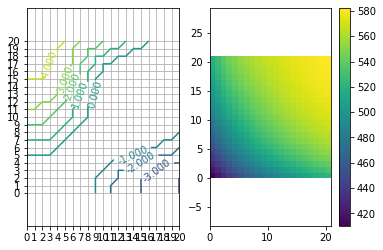

In [19]:
import matplotlib.pylab as plt

plt.subplot(121)
CS = plt.contour(solver.policy, levels=range(-6, 6))
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid('on')

plt.subplot(122)
plt.pcolor(solver.value)
plt.colorbar()
plt.axis('equal')

plt.show()